Below are imports that are always added 

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

Understanding how derivatives work. $f(x) = 3x^2 - 4x + 5$ 

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

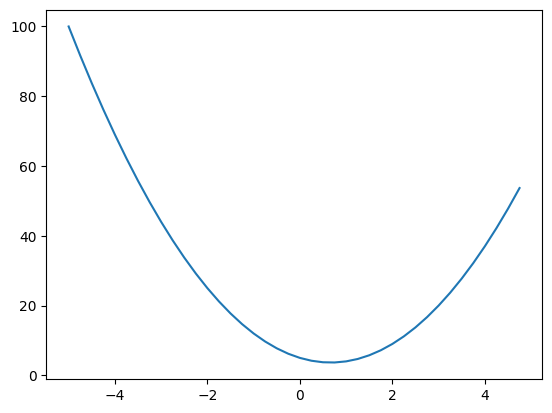

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

If we were to nudge x ever so slightly, then how much does it change? Just recall Blakely's class (the goat)

In [7]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h

0.0

But what if we have multiple inputs?

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print (d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b +c 

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


# Building Micrograd
Now we get into building the neural network

Below is simply a "node" for tracking a singlular scalar value. We will overload the simple operations.

In [68]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # maintains the derivative of L, with respect to the value. 0 indicates that the current value does NOT affect the output
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"(Value(data={self.data}))"
        
    # overloads +
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
        
    # overloads *
    def __mul__(self, other):
        return Value(self.data * other.data, (self,other), '*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label="f")
L = d * f; L.label="L"
L


(Value(data=-8.0))

## Children
We added in children variables to remember the values used to get to the current one `_children`. We also need to remember the operation used `_op`.

In [11]:
print(d._op)
print(d._prev)

+
{(Value(data=-6.0)), (Value(data=10.0))}


Below is code to visualize how we got to our current value. 

In [36]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes by going through children Values
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
        

This is visualizing the *forward pass* of L

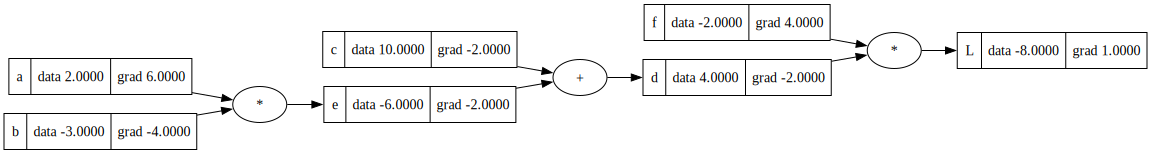

In [59]:
draw_dot(L)

## Manual Back Propagation

Now let us implement back propagation, where we simply go in the reverse direction and calculate the gradient with respect to L. For every single value, we compute the derivative of the node with respect to L. 

In the future, the intermediate values represent weights which impact the loss function, L. Using back propagation gives us more information on the intermediate values.

We want to find the derivative of `c`. We can do so by finding it with respect to `d`. Karparthy calls it the 'local derivative', which makes sense. 

However, we need to know the derivative with respect to L. So how do we do this? By using Chain Rule:
$$\dfrac{dz}{dx} = \dfrac{dz}{dy} \cdot \dfrac{dy}{dx}$$ 

We want:
$$\dfrac{dL}{dc} = \dfrac{dL}{dd} \cdot \dfrac{dd}{dc}$$ 

In [51]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data

When we use the $+$ operation, you can imagine it as simply distributing the grad to its leaf nodes. This is because the $+$ operation does not affect the rate of change, it simply shifts it up or down, which in a derivative is meaningless.

In [58]:
c.grad = d.grad * 1
e.grad = d.grad * 1

a.grad = (e.grad * b.data)
b.grad = (e.grad * a.data)

Remember that we can simply verify our these manually inserted grads by updating the variables respectively in `lol()`

In [87]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label="f")
    L = d * f; L.label="L"
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label="f")
    L = d * f; L.label="L"
    L2 = L.data

    print ((L2 - L1) / h)

lol()

-4.000000000008441


We have essentially derived back propagation; a recursive application of Chain Rule. Now that we know how much each variable affects L, we can experiment:

In [60]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f

print(L.data)

-7.286496


## Back Propagating Through a Neuron

#### Overview of a neural network
![neural network](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

#### Mathmatical representation of a neuron
![math mathmatical represention of neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

$w$ represents the weight, which is the grad we are most interested in. Essentially a bunch of different inputs can be sent to the cell body, where it sums everything, with a bit of bias, $b$, and sends it to the activation function. The activation function is typically a [squashing function](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html) (Basically limits any input [-1,1]):

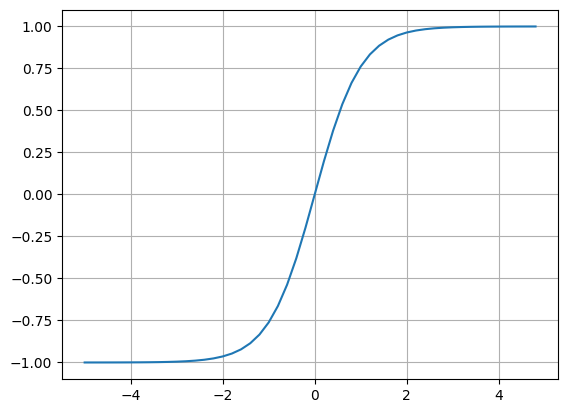

In [64]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [129]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2= x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# n = the cell body without the activation function
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

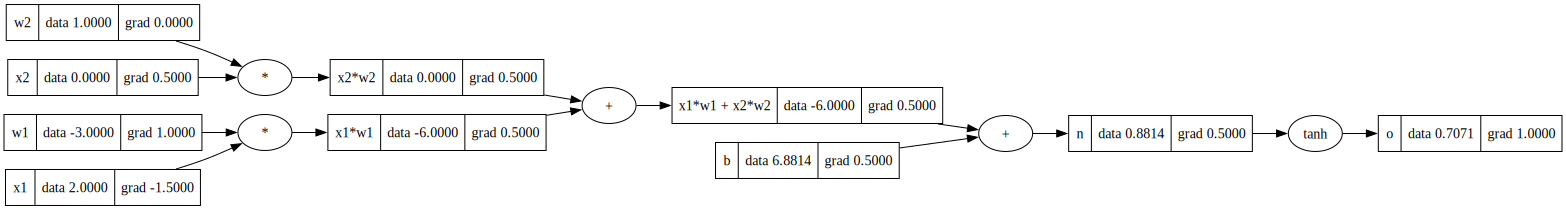

In [132]:
draw_dot(o)

In [115]:
o.grad = 1

# Derivative of tanh(x)
n.grad = 1-(o.data**2)

b.grad = n.grad
x1w1x2w2.grad = n.grad

x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

Notice that when `x2.data = 0`, the gradient for `w2 = 0` as well. Think about it intuitively. We multiply anything by 0, there would be no effect on the outcome.

This is important to note, because my previous line of thought was that gradients are simply set and stone, but here we obviously see that they are reliant on the value.

## Back propagation function

In [128]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # maintains the derivative of L, with respect to the value. 0 indicates that the current value does NOT affect the output
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"(Value(data={self.data}))"
        
    # overloads +
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out
        
    # overloads *
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += 1-(t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label="f")
L = d * f; L.label="L"
L

(Value(data=-8.0))

In [100]:
# Set the base case
o.grad = 1.0

In [102]:
o._backward()

In [104]:
n._backward()

In [ ]:
b._backward()

In [107]:
x1w1x2w2._backward()

In [109]:
x2w2._backward()

In [111]:
x1w1._backward()

Now how do we automate calling the `._backward()`? 

We use a Topological Sort, where all the edges only go one way, from left to right. We put the bottom function into Value()

In [119]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()


In [131]:
o.backward()

## Bugs in Backprop

Below is an example of a very specific bug that will occur in our code above. Since we are using the exact same object, we are overriding it in our `_backward()` code.

Basically we will see an issue when we use a variable more than once. The solution is very simple, rather than explicitly setting using `=`, just use `+=`. Changes will be shown above.

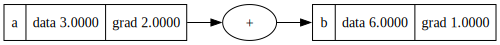

In [133]:
a = Value(3.0, label='a')
b = a + a; b.label ='b'
b.backward()
draw_dot(b)

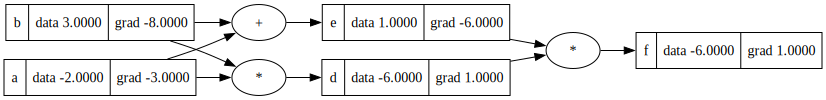

In [134]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

## Implementing other operations

We will implement
- power
- division
- subtraction

In [466]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # maintains the derivative of L, with respect to the value. 0 indicates that the current value does NOT affect the output
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"(Value(data={self.data}))"
        
    # overloads +
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out
        
    # overloads *
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    # catches cases like 2 * a
    def __rmul__ (self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-(t**2)) * out.grad # i forgot to add parenthesis around 1-t**2. completely fucked everything
            
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self,other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [162]:
a = Value(2.0)
b = Value(4.0)

a / b

(Value(data=0.5))

In [163]:
a - b

(Value(data=-2.0))

In [164]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2= x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# n = the cell body without the activation function
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

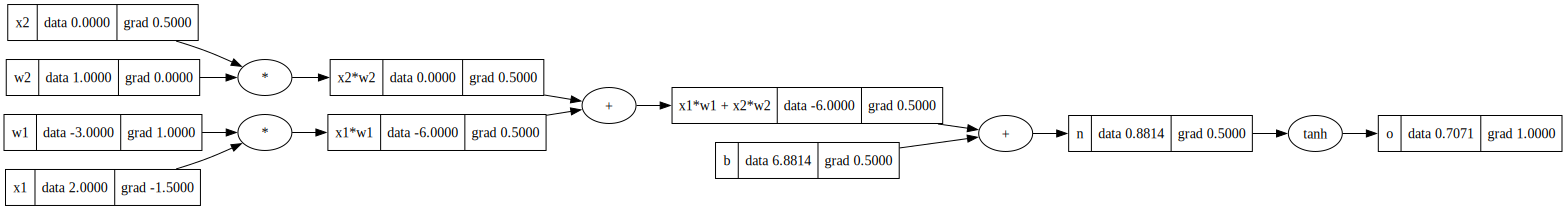

In [165]:
draw_dot(o)

Here we will show how to define $\tanh$ as atomic operations, 
$$\dfrac{e^{2x} - 1}{e^{2x} + 1}$$

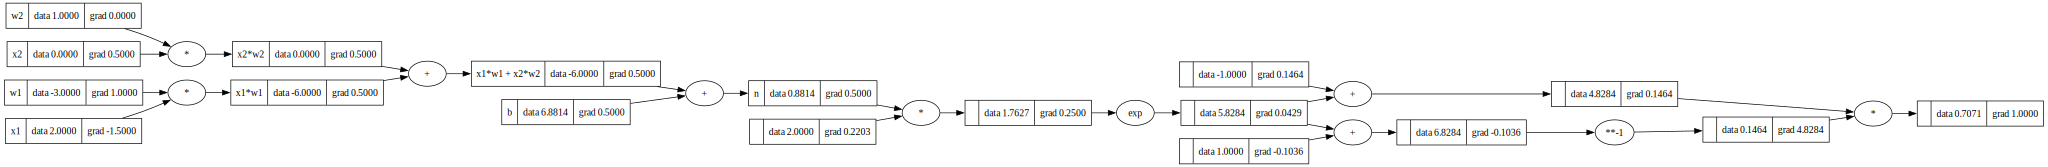

In [166]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2= x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# n = the cell body without the activation function
n = x1w1x2w2 + b; n.label = 'n'

# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.backward()
draw_dot(o)

The point of is to show that no matter how you create your operations, the value to be inputted must be outputted in some way, so long as it's equivalent.

## Constructing a Neural Network

Recall: 

![math mathmatical represention of neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

$w$ means the amount of inputs sent into the cell body, which in the case of the picture above would be 3. We assign a random weight between $[-1,1]$

In [453]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  # "cell body"
  def __call__(self, x):
    # w * x + b
    # zip takes two iterators and creates a new iterator that iterates the tuples        
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
      
# creates a list of independent neurons
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [467]:
# example input
x = [2.0, 3.0, -1.0]

n = MLP(3,[4,4,1])
n(x)

(Value(data=0.7207659398306022))

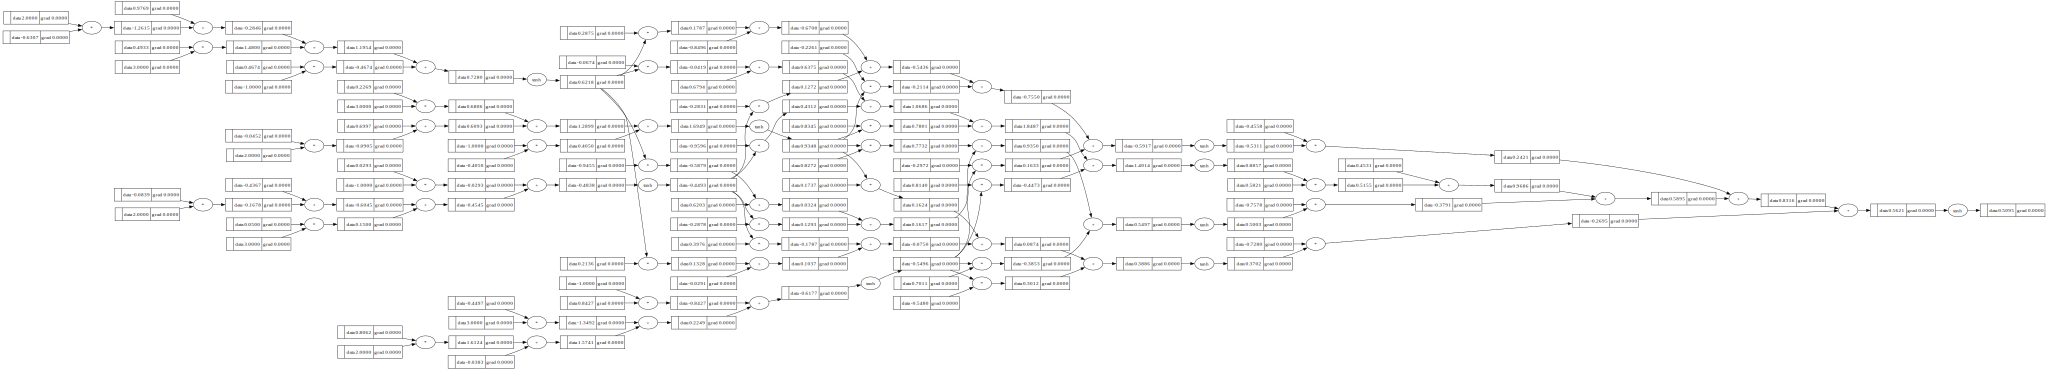

In [113]:
draw_dot(n(x))

### Loss Function
We have a set of input data, $xs$. We want to end with $ys$. So how do we change the weights accordingly, to reach the desired outcome?

The trick is to calculate a *single* number that represents the performance of the entire neural network, known as the **loss**

Let's start with an example

In [468]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Implementing the mean squared error loss. The square here just makes it so that the closer it is, the less it needs to change, and the further away, the greater the need for change. It also prevents negative numbers.

In [229]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[(Value(data=0.0)),
 (Value(data=2.3697632058747253e-09)),
 (Value(data=2.3697632058747253e-09)),
 (Value(data=0.0))]

In [230]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

(Value(data=4.739526411749451e-09))

In [388]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

(Value(data=4.395112659113815e-07))

What we do below is HUGE. We calculate the gradient descent with respect to the **loss**, rather than the output. So now we know which weights for the specific neuron in the specific layer would affect the loss value.

In [386]:
loss.backward()

Beautiful.

It's worth noting here that the inputs having gradients is meaningless. We CANNOT change the inputs, because they should be a given. Imagine ChatGPT asking you to change your input because your gradient was too high.

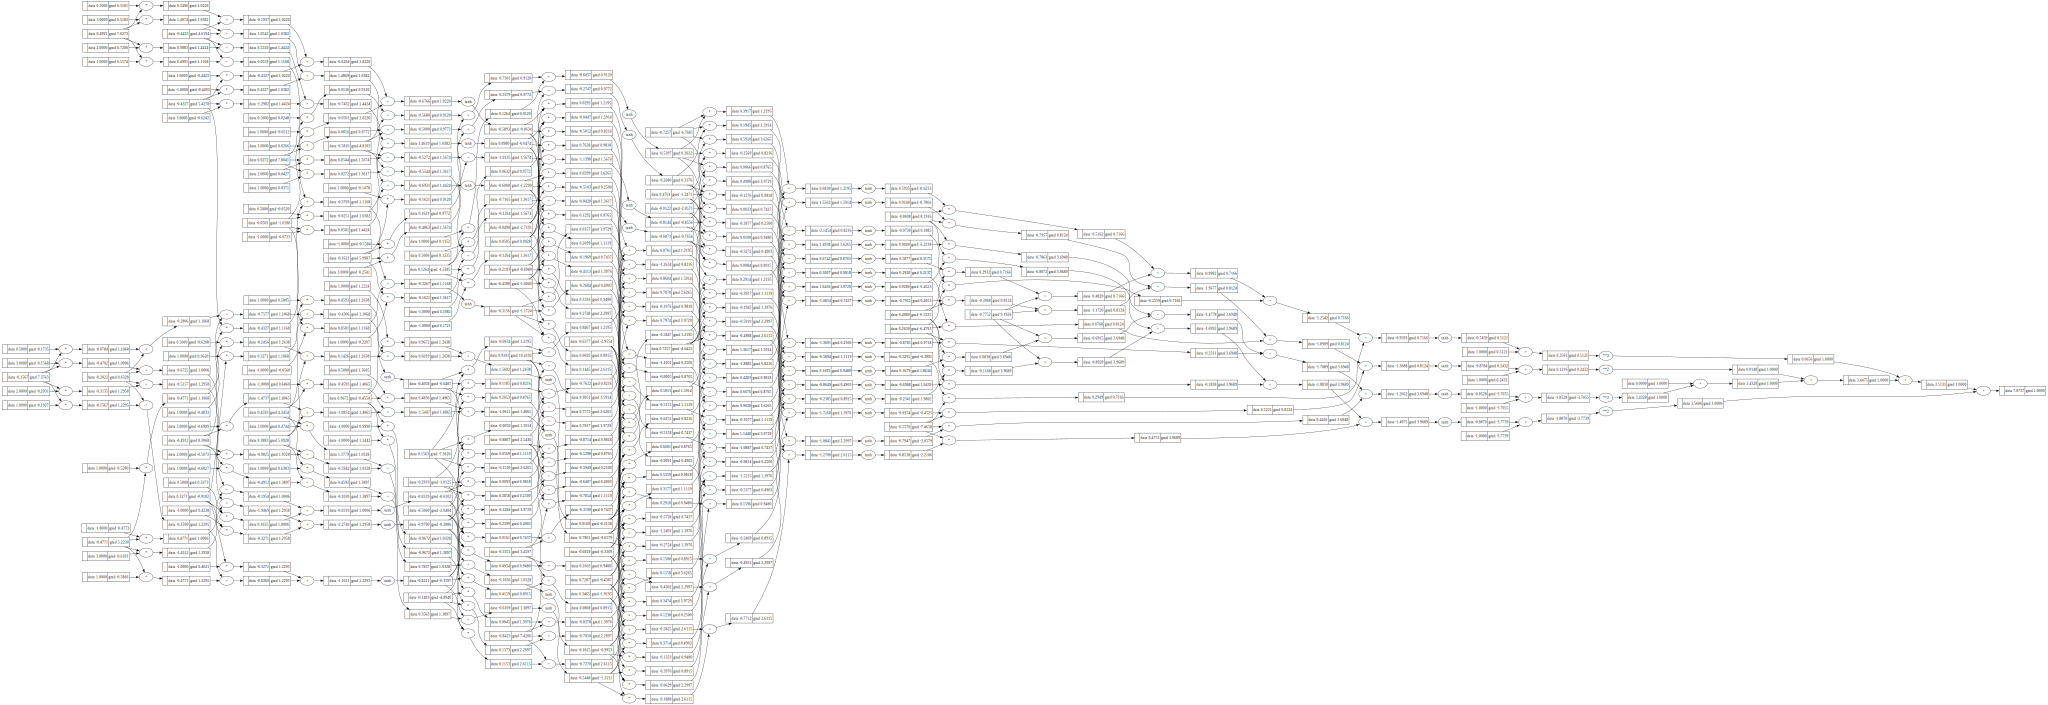

In [233]:
draw_dot(loss)

#### Below is gradient descent!
$0.01 *$ p.grad maximizes the loss, then multiplying by a negative will minimize the loss.

In [476]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 0.019944566430209816
1 0.019395328973359105
2 0.018873822767377806
3 0.01837805382897695
4 0.01790621189642034
5 0.017456649970075712
6 0.017027866506197642
7 0.016618489873429777
8 0.01622726474553255
9 0.015853040156335048
10 0.015494758986136371
11 0.015151448684512188
12 0.014822213064133387
13 0.014506225024896884
14 0.014202720088306739
15 0.013910990639349884
16 0.013630380787672758
17 0.01336028177215036
18 0.013100127843344932
19 0.012849392567181057


In [477]:
ypred

[(Value(data=0.9534575795300886)),
 (Value(data=-0.9557697206740206)),
 (Value(data=-0.9313456610836869)),
 (Value(data=0.9366481270782554))]

# Summary
1. Use back propagation to get the gradients
2. Then use gradient descent to get the loss as low as possible
3. Repeat step 2 until loss function is acceptable

What we've created is only a Neural Network with 41 parameters. 